In [1]:
%load_ext autoreload
%autoreload 2
from transformers import BertModel, DistilBertModel
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import datasets
import numpy as np
import os.path
from datasets import load_from_disk
import pickle as pkl
from sklearn.linear_model import LogisticRegressionCV
from collections import defaultdict
from copy import deepcopy
from tqdm import tqdm
import dvu
dvu.set_style()
import pandas as pd
import config
from os.path import join as oj
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

2022-06-28 13:08:17.565448: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-28 13:08:17.565520: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
dsets = os.listdir(config.data_dir)
rs = []
for dset in dsets:
    # depending on how much is saved, this may take a while
    results_dir = oj(config.results_dir, dset)
    dir_names = sorted([fname
                        for fname in os.listdir(results_dir)
                        if os.path.isdir(oj(results_dir, fname))
                        and not '-norm' in fname
                       ])
    # print(dir_names)

    results_list = [pd.Series(pkl.load(open(oj(results_dir, dir_name, 'results.pkl'), "rb")))
                    for dir_name in tqdm(dir_names)]
    r = pd.concat(results_list, axis=1).T.infer_objects().drop(columns='model')
    r = r.fillna('')
    r['all'] = r['all'].replace('True', 'all')
    r['dataset'] = dset
    rs.append(r)
rs = pd.concat(rs)

100%|██████████| 28/28 [00:21<00:00,  1.33it/s]


In [14]:
rs

,checkpoint,ngrams,subsample,all,norm,dataset,padding,dataset_key_text,num_features,acc_train,acc_val
0,bert-base-uncased,1,-1,,,emotion,True,text,768,0.533500,0.530500
1,countvectorizer,1,-1,,,emotion,True,text,15165,0.993313,0.887500
2,nateraw/bert-base-uncased-emotion,1,-1,,,emotion,True,text,768,0.891250,0.876000
3,tfidfvectorizer,1,-1,,,emotion,True,text,15165,0.995687,0.893500
4,countvectorizer,1,1000,,,emotion,True,text,3295,1.000000,0.591000
5,tfidfvectorizer,1,1000,,,emotion,True,text,3295,1.000000,0.636500
6,countvectorizer,1,100,,,emotion,True,text,740,0.690000,0.344000
7,tfidfvectorizer,1,100,,,emotion,True,text,740,1.000000,0.352000
8,bert-base-uncased,2,-1,,,emotion,True,text,768,0.555500,0.554000
9,countvectorizer,2,-1,,,emotion,True,text,121366,0.998125,0.887500


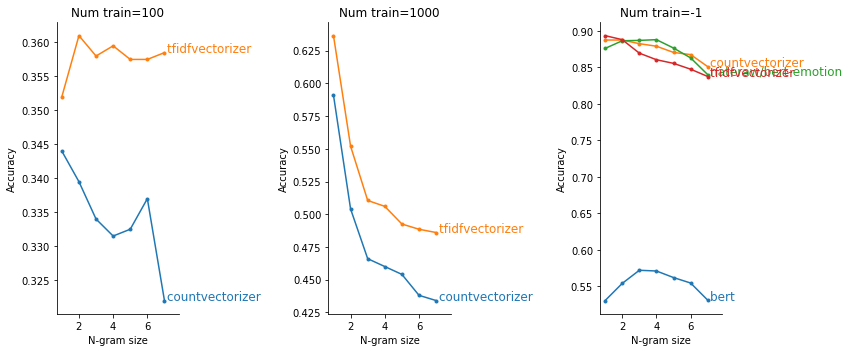

In [12]:
r = rs[rs.dataset == 'emotion']

R = 1
C = 3
plt.figure(figsize=(12, 5))
# plt.figure(figsize=(8, 12))
for i, subsample in enumerate([100, 1000, -1]):
    plt.subplot(R, C, i + 1)
    plt.title('Num train=' + str(subsample))
    d = r[r.subsample == subsample]
    
    curve = d.groupby(['checkpoint', 'all', 'norm'])
    for key, group in curve:
        g = group.sort_values('ngrams')
        plt.plot(g.ngrams, g.acc_val, '.-',
                 label=(
                     ' '.join(key)
                     .replace('textattack/bert-base-uncased-SST-2', 'bert-sst2')
                     .replace('bert-base-uncased', 'bert')
                 ))
    plt.ylabel('Accuracy')
    plt.xlabel('N-gram size')

    
#     plt.legend()
    dvu.line_legend(fontsize=12)
    
plt.tight_layout()
plt.savefig('results/acc_by_ngrams_sst.pdf')
#     print(curve)

In [ ]:
##### (
r.sort_values(by=['subsample', 'acc_val'], ascending=False)
#     .fillna('')
#     .replace('', False)
# )